### 1. Preparation

In [1404]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary
from sklearn.metrics import confusion_matrix, f1_score, roc_curve

import time
import random
import copy

In [1405]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(42)

### 2. Data Loading & Preprocessing

**Helper Functions**

In [1406]:
def load_from_yf(ticker, period="10y", interval="1d"):
    df: pd.DataFrame = yf.Ticker(ticker).history(period=period, interval=interval)
    return df[["Open", "High", "Low", "Close"]], df[["Volume"]]

In [1407]:
def normalized(df: pd.DataFrame):
    return (df - df.mean()) / df.std()

**Input Data**

In [1447]:
ticker = "TSLA"

In [1448]:
price, vol = load_from_yf(ticker)
print("Data size:", len(vol))

nl_price = normalized(np.log(price))
n_price = normalized(price)
n_vol = normalized(vol)

trainsize = (int) (len(vol[120:]) * 0.8)
valsize = (int) (len(vol[120:]) * 0.1)
testsize = len(vol[120:]) - trainsize - valsize

data = np.concatenate([nl_price, n_price, n_vol], axis=1)
close = price[["Close"]].to_numpy()

Data size: 2518


**Label**

In [1449]:
change = [0] + [close[i+1]/close[i]-1 for i in range(len(data)-1)]
label = [0 if change[i] <= 0 else 1 for i in range(len(data))]

unique, counts = np.unique(label[120:], return_counts=True) 
print("Data ratio: ", dict(zip(unique, counts)))

Data ratio:  {0: 1140, 1: 1258}


### 3. Models & Training

In [1411]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(in_features=600, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=10)
        self.fc5 = nn.Linear(in_features=10, out_features=2)
    
    def forward(self, input):
        x = nn.Flatten()(input)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = F.tanh(self.fc5(x))
        x = nn.Softmax(dim=1)(x)
        return x

In [1412]:
class LeNet2(nn.Module):
    def __init__(self):
        super(LeNet2, self).__init__() # 120
        self.conv1 = nn.Conv1d(in_channels=9, out_channels=30, kernel_size=5) # 116
        self.maxp1 = nn.MaxPool1d(kernel_size=2, stride=2) # 58
        self.conv2 = nn.Conv1d(in_channels=30, out_channels=30, kernel_size=5) # 54
        self.maxp2 = nn.MaxPool1d(kernel_size=2, stride=2) # 27
        self.conv3 = nn.Conv1d(in_channels=30, out_channels=10, kernel_size=5) # 23
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=230, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.activation = nn.Softmax(dim=1)
        
    def forward(self, input):
        x = self.maxp1(self.conv1(input))
        x = self.maxp2(self.conv2(x))
        x = self.flatten(self.conv3(x))
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        x = self.activation(x)
        return x

In [1413]:
class RedLeNet(nn.Module):
    def __init__(self):
        super(RedLeNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=30, kernel_size=5) # 16
        self.conv2 = nn.Conv1d(in_channels=30, out_channels=30, kernel_size=5) # 12
        self.conv3 = nn.Conv1d(in_channels=30, out_channels=10, kernel_size=5) # 8
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=80, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.activation = nn.Softmax(dim=1)

    def forward(self, input):
        x = input[:,:,-20:]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.activation(x)
        return x

In [1414]:
class CatNet(nn.Module):
    def __init__(self):
        super(CatNet, self).__init__()
        self.conv11 = nn.Conv1d(in_channels=9, out_channels=20, kernel_size=50 ,stride=10)
        self.conv12 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, stride=1)
        self.conv13 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size=2, stride=1)

        self.conv21 = nn.Conv1d(in_channels=9, out_channels=20, kernel_size=15 ,stride=5)
        self.conv22 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, stride=1)
        self.conv23 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size=2, stride=1)

        self.conv31 = nn.Conv1d(in_channels=9, out_channels=20, kernel_size=5 ,stride=1)
        self.conv32 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, stride=1)
        self.conv33 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size=2, stride=1)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=280, out_features=400)
        self.fc2 = nn.Linear(in_features=400, out_features=400)
        self.fc3 = nn.Linear(in_features=400, out_features=40)

        self.fc4 = nn.Linear(in_features=67, out_features=20)
        self.fc5 = nn.Linear(in_features=20, out_features=20)
        self.fc6 = nn.Linear(in_features=20, out_features=2)

        self.do1 = nn.Dropout()
        self.do2 = nn.Dropout()
        self.do3 = nn.Dropout()
        self.do4 = nn.Dropout()

        self.activation = nn.Softmax(dim=1)

    def forward(self, input, train=False):

        input1 = input
        input2 = input[:,:,60:]
        input3 = input[:,:,100:]
        last = input[:,:,-3:]

        x1 = self.conv11(input1)
        x1 = self.conv12(x1)
        x1 = self.conv13(x1)

        x2 = self.conv21(input2)
        x2 = self.conv22(x2)
        x2 = self.conv23(x2)

        x3 = self.conv31(input3)
        x3 = self.conv32(x3)
        x3 = self.conv33(x3)

        x1 = self.flatten(x1)
        x2 = self.flatten(x2)
        x3 = self.flatten(x3)

        x = torch.concat((x1, x2, x3), dim=1)

        x = self.do1(self.fc1(F.relu(x)))
        x = self.do2(self.fc2(F.relu(x)))
        x = self.do3(self.fc3(F.relu(x)))

        last = self.flatten(last)
        x = torch.concat((x, last), dim=1)

        x = self.do4(self.fc4(x))
        x = self.fc5(F.relu(x))
        x = self.fc6(F.relu(x))

        x = self.activation(x)

        return x
        

**Training Hyperparameters**

In [1415]:
net = CatNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

epochs = 50

**Model Status**

In [1424]:
netname = ticker + '_' + net.__class__.__name__

#summary(net, (9, 120))

print(net, file=open(f"../Record/{netname}_Model.txt", "w"))

**Training**

In [1417]:
runlosslist, runacclist = [], []
vallosslist, valacclist = [], []
for epoch in range(epochs):
    epochstart = time.time()

    net.train()
    runloss, runcorrect = 0, 0
    for i in range(trainsize):
        optimizer.zero_grad()

        input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
        target = torch.tensor([label[i+120]])

        output = net(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        runcorrect += (predicted == target).sum().item()
        runloss += loss.item()
    runacc = runcorrect/trainsize
    runacclist.append(runacc)
    runlosslist.append(runloss)

    net.eval()
    valloss, valcorrect = 0, 0
    with torch.no_grad():
        for i in range(trainsize, trainsize+valsize):
            input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
            target = torch.tensor([label[i+120]])

            output = net(input)
            loss = criterion(output, target)

            _, predicted = torch.max(output.data, 1)
            valcorrect += (predicted == target).sum().item()
            valloss += loss.item()
    valacc = valcorrect/valsize
    valacclist.append(valacc)
    vallosslist.append(valloss)

    epochtime = time.time() - epochstart

    print(f"Epoch {epoch+1:2}/{epochs}: Run loss = {runloss:7.2f} | Run acc = {runacc*100:5.2f}% | Val loss = {valloss:7.2f} | Val acc = {valacc*100:2.2f}% | {epochtime:2.1f}s")
    

Epoch  1/50: Run loss = 1359.95 | Run acc = 51.41% | Val loss =  174.82 | Val acc = 56.07% | 10.7s
Epoch  2/50: Run loss = 1357.62 | Run acc = 49.64% | Val loss =  183.33 | Val acc = 49.37% | 9.3s
Epoch  3/50: Run loss = 1349.69 | Run acc = 51.20% | Val loss =  177.00 | Val acc = 55.23% | 9.1s
Epoch  4/50: Run loss = 1336.04 | Run acc = 50.57% | Val loss =  172.03 | Val acc = 54.39% | 9.1s
Epoch  5/50: Run loss = 1361.83 | Run acc = 50.63% | Val loss =  176.91 | Val acc = 51.05% | 9.2s
Epoch  6/50: Run loss = 1329.62 | Run acc = 51.51% | Val loss =  166.35 | Val acc = 59.41% | 10.1s
Epoch  7/50: Run loss = 1329.74 | Run acc = 51.25% | Val loss =  173.63 | Val acc = 58.58% | 8.6s
Epoch  8/50: Run loss = 1361.91 | Run acc = 51.51% | Val loss =  184.14 | Val acc = 53.56% | 8.7s
Epoch  9/50: Run loss = 1350.96 | Run acc = 50.73% | Val loss =  188.46 | Val acc = 49.79% | 8.9s
Epoch 10/50: Run loss = 1327.37 | Run acc = 52.29% | Val loss =  181.15 | Val acc = 48.95% | 8.9s
Epoch 11/50: Run l

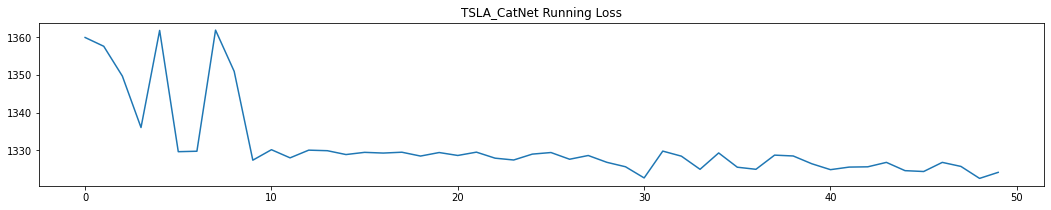

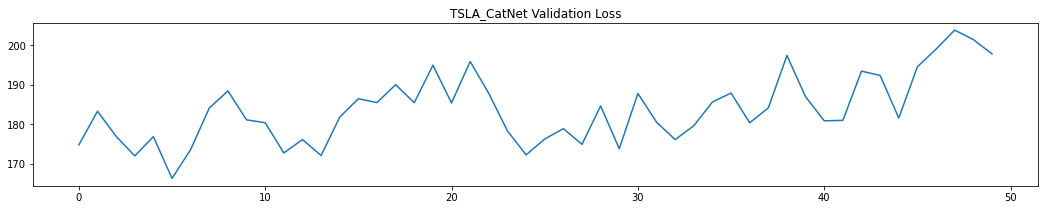

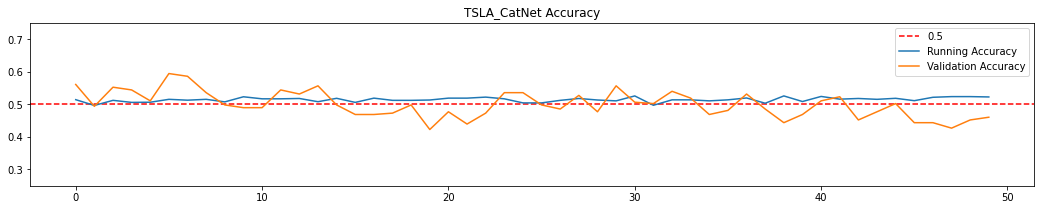

In [1418]:
plt.figure(figsize=(18,3))
plt.plot(runlosslist)
plt.title(f"{netname} Running Loss")
plt.savefig(f"../Record/{netname}_RunLoss")

plt.figure(figsize=(18,3))
plt.plot(vallosslist)
plt.title(f"{netname} Validation Loss")
plt.savefig(f"../Record/{netname}_ValLoss")

plt.figure(figsize=(18,3))
plt.ylim((0.25, 0.75))
plt.axhline(y = 0.5, color = 'r', linestyle = 'dashed', label="0.5")
plt.plot(runacclist, label="Running Accuracy")
plt.plot(valacclist, label="Validation Accuracy")
plt.title(f"{netname} Accuracy")
plt.legend(loc="upper right")
plt.savefig(f"../Record/{netname}_Accuracy")

### 4. Evaluation

In [1058]:
net = torch.load("./FB_CatNet_model.pt")

<bound method Module.state_dict of CatNet(
  (conv11): Conv1d(9, 20, kernel_size=(50,), stride=(10,))
  (conv12): Conv1d(20, 20, kernel_size=(2,), stride=(1,))
  (conv13): Conv1d(20, 10, kernel_size=(2,), stride=(1,))
  (maxp1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv1d(9, 20, kernel_size=(15,), stride=(5,))
  (conv22): Conv1d(20, 20, kernel_size=(2,), stride=(1,))
  (conv23): Conv1d(20, 10, kernel_size=(2,), stride=(1,))
  (maxp2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv1d(9, 20, kernel_size=(5,), stride=(1,))
  (conv32): Conv1d(20, 20, kernel_size=(2,), stride=(1,))
  (conv33): Conv1d(20, 10, kernel_size=(2,), stride=(1,))
  (maxp3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=280, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3)

In [1440]:
threshold = 0.7

Threshold: 0.70 | Confident = 214/241
Test acc = 42.52%
F1 score: 0.37


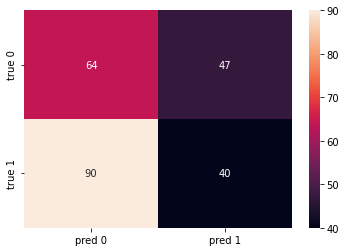

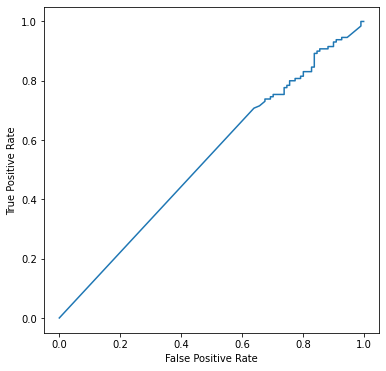

In [1490]:
net.eval()

conflist, predlist = [], []
confsize, confcorrect = 0, 0
with torch.no_grad():
    for i in range(trainsize+valsize, trainsize+valsize+testsize):
        input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
        target = torch.tensor([label[i+120]])
        output = k(input)
        _, predicted = torch.max(output.data, 1)

        conflist.append(_.item())
        predlist.append(predicted.item())
        if _.item() >= threshold:
            confsize += 1
            confcorrect += (predicted == target).sum().item()
testacc = 0 if confsize==0 else confcorrect/confsize
print(f"Threshold: {threshold:.2f} | Confident = {confsize}/{testsize}")
print(f"Test acc = {testacc*100:2.2f}%")

cm = confusion_matrix(label[120+trainsize+valsize:], predlist)
df_cm = pd.DataFrame(cm, index=["true 0", "true 1"], columns=["pred 0", "pred 1"])
sb.heatmap(df_cm, annot=True)
plt.savefig(f"../Record/{netname}_CM")

print(f"F1 score: {f1_score(label[120+trainsize+valsize:], predlist):.2f}")

fpr, tpr, _ = roc_curve(label[120+trainsize+valsize:],  conflist)
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 5. Simulation

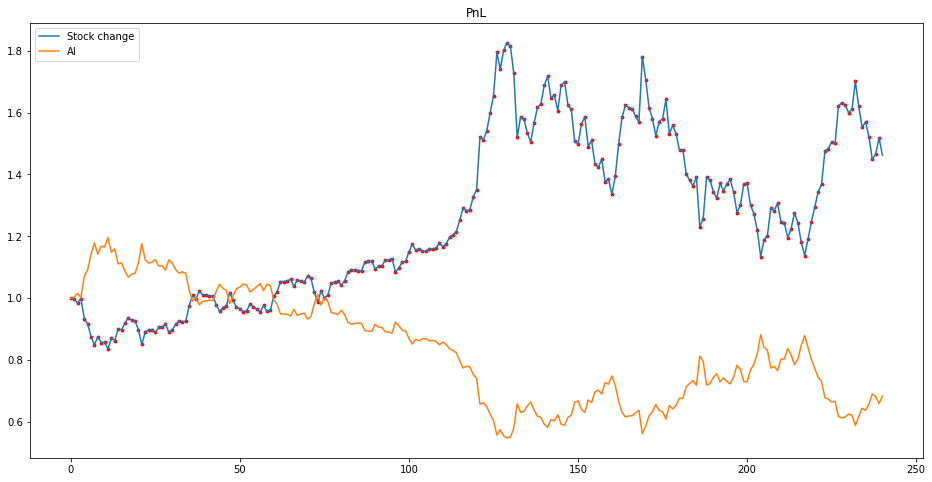

Stock change: 46.23%
Profit/Loss:  -31.61%


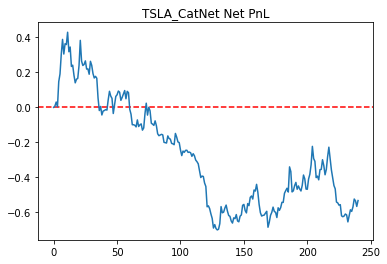

Net PnL:      -53.23%


In [1477]:
stockchangelist = [(close[-testsize+i]/close[-testsize]).item() for i in range(testsize)]

pnl, pnllist = 1, [1]
buytime, buyprice = [], []
selltime, sellprice = [], []
for i in range(testsize-1):
    if conflist[i] >= threshold:
        if predlist[i] == 1: 
            buytime.append(i)
            buyprice.append(stockchangelist[i])
            pnl *= (close[-testsize+i+1] / close[-testsize+i]).item() # BUY
        else:
            selltime.append(i)
            sellprice.append(stockchangelist[i])
            pnl *= (close[-testsize+i] / close[-testsize+i+1]) # SELL
    pnllist.append(pnl.item())

plt.figure(figsize=(16,8))
plt.title("PnL")
plt.plot(stockchangelist, label="Stock change")
plt.plot(pnllist, label="AI")
plt.scatter(buytime, buyprice, s=8, c="green")
plt.scatter(selltime, sellprice, s=8, c="red")
plt.legend(loc="upper left")
plt.savefig(f"../Record/{netname}_Simulation")
plt.show()

print(f"Stock change: {(stockchangelist[-1]-1)*100:.2f}%")
print(f"Profit/Loss:  {(pnllist[-1]-1)*100:.2f}%")

extralist = [pnllist[i]/stockchangelist[i]-1 for i in range(testsize)]

plt.title(f"{netname} Net PnL")
plt.axhline(y = 0, color = 'r', linestyle = 'dashed')
plt.plot(extralist)
plt.savefig(f"../Record/{netname}_NetPnL")
plt.show()

print(f"Net PnL:      {extralist[-1]*100:.2f}%")


In [1487]:
torch.save(net.state_dict(), f"../Record/{netname}_model.pt")
k = CatNet()
k.load_state_dict(torch.load(f"../Record/{netname}_model.pt"))

<All keys matched successfully>